**Problem background:**
- Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it.
-	Infection causes Inflammation in the air sacs (alveoli)  in your lungs 
-	Alveoli,  take up the oxygen you breathe in and keep your body going. Although they’re microscopic, alveoli are the workhorses of your respiratory system.
-	480 million alveoli, located at the end of bronchial tubes. When you breathe in, the alveoli expand to take in oxygen. When you breathe out, the alveoli shrink to expel carbon dioxide.
- following test are performed for the diagonis 
  - Chest X-ray / CT scan
  - Blood test
  - Bronchoscope 

  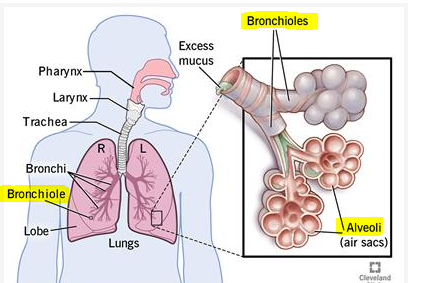

  


**Problem Statement**- Pneumonia detection 

**Why ?**
 - Diagnosis is a complex process and requred a highely trained specialist 
 - Cost informed in the diagnosis

**What ?** 
  - Create a ML model which read the CXR images and locate the postion of the inflammation 

**How ?**

 - Approach - 1 
  - stacking models - Image classification ( to check is affected by Pneumonia or not ) and If the patient affected by Pneumonia then inputs are passed to second model to locate the inflammation
 - Approach 2 - Single model to locate the inflammation. 

 - Metrics - Recall will be the evaluation metrics ( Since it's important to indentify the person affected by Pneumonia )

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing lib

In [5]:
pip install pydicom

     |████████████████████████████████| 1.9 MB 6.4 MB/s 


In [18]:
import pandas as pd
import numpy as np
import os
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import cv2


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image,ImageDraw,ImageOps


In [7]:
DATA_ROOT_PATH = "/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/"
META_DATA = os.path.join(DATA_ROOT_PATH,"stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv")
TRAIN_LABEL = os.path.join(DATA_ROOT_PATH,"stage_2_train_labels.csv/stage_2_train_labels.csv")
TRAIN_FOLDER = os.path.join(DATA_ROOT_PATH,"stage_2_train_images")
TEST_FOLDER = os.path.join(DATA_ROOT_PATH,"stage_2_test_images")

DATA_ROOT_PATH,META_DATA, TRAIN_LABEL,TRAIN_FOLDER,TEST_FOLDER

('/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_train_labels.csv/stage_2_train_labels.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_train_images',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_test_images')

### Reading Data

In [8]:
meta_data = pd.read_csv(META_DATA)
meta_data.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


Shape of data (30227, 2)
----------------

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64
----------------



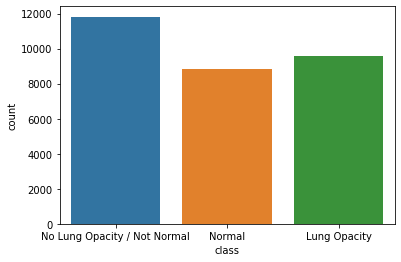

In [9]:
### Distribution od the class
print("Shape of data",meta_data.shape)
print("----------------\n")

print(meta_data["class"].value_counts())
print("----------------\n")

sns.countplot(data=meta_data,x="class")

In [10]:
train_data = pd.read_csv(TRAIN_LABEL)
train_data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Shape of data (30227, 6)
----------------

0    20672
1     9555
Name: Target, dtype: int64
----------------



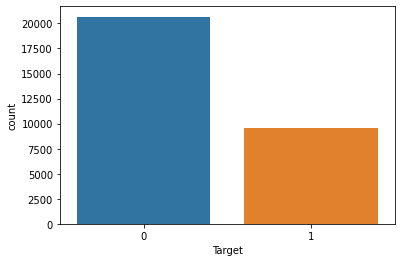

In [11]:
### Distribution of the class
print("Shape of data",train_data.shape)
print("----------------\n")

print(train_data["Target"].value_counts())
print("----------------\n")

sns.countplot(data=train_data,x="Target")

In [12]:
train_img_list = os.listdir(TRAIN_FOLDER)
print("Total train image",len(train_img_list))

test_img_list = os.listdir(TEST_FOLDER)
print("Total train image",len(test_img_list))

Total train image 26694
Total train image 3000


In [56]:
patientId = []
age = []
sex = []

for image_name in train_img_list:
  file_name = os.path.join(TRAIN_FOLDER,image_name)
  ds = dicom.read_file(file_name)
  patientId.append(ds.PatientID)
  age.append(ds.PatientAge)
  sex.append(ds.PatientSex)

for image_name in test_img_list:
  file_name = os.path.join(TEST_FOLDER,image_name)
  ds = dicom.read_file(file_name)
  patientId.append(ds.PatientID)
  age.append(ds.PatientAge)
  sex.append(ds.PatientSex)

patient_data = pd.DataFrame(columns=["patientId","age","sex"])
patient_data["patientId"] = patientId
patient_data["age"] = age
patient_data["sex"] = sex

patient_data.head()



KeyboardInterrupt: ignored

In [53]:
file_name = os.path.join(TRAIN_FOLDER,train_img_list[20])
ds = dicom.read_file(file_name)
ds.PatientSex,ds.PatientAge,ds.ViewPosition,ds.PatientID

('M', '60', 'AP', 'f7963c46-8d6f-43c0-bfb1-b7d41dd0cc6c')

In [37]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    img = dicom.dcmread(path)    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(img.pixel_array, img)
    else:
        data = img.pixel_array               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and img.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)        
    return data

In [34]:
# Visualize the image 
infected_id = train_data.query("Target == 1").index
not_infected_id = train_data.query("Target == 0").index


def plot_images(id_list):
  plt.figure(figsize=(10, 10))
  for i in range(9):
      index = id_list[np.random.randint(0,100)]
      file_name = os.path.join(TRAIN_FOLDER,train_img_list[index])
      img = read_xray(file_name)
      #img = dicom.dcmread(file_name).pixel_array
      #print(img.size)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(img)
      if str(train_data.iloc[index]["Target"]) == "1":
        x = int(train_data.iloc[index]["x"])
        y = int(train_data.iloc[index]["y"])
        width = int(train_data.iloc[index]["width"])
        height = int(train_data.iloc[index]["height"])
        #print(int(x),int(y),(int(x+width), int(y+height)))
        rect = Rectangle((x,y), width,height, linewidth=2, fill=False,color="red")
        ax.add_patch(rect)
      plt.title(meta_data.iloc[index]["class"] +" Target --"+str(train_data.iloc[index]["Target"]) )
      #plt.axis("off")
  plt.show()    


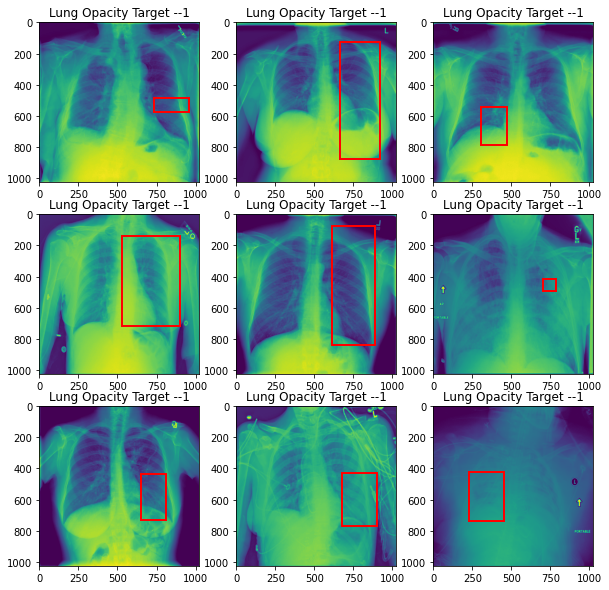

In [35]:
plot_images(infected_id) 


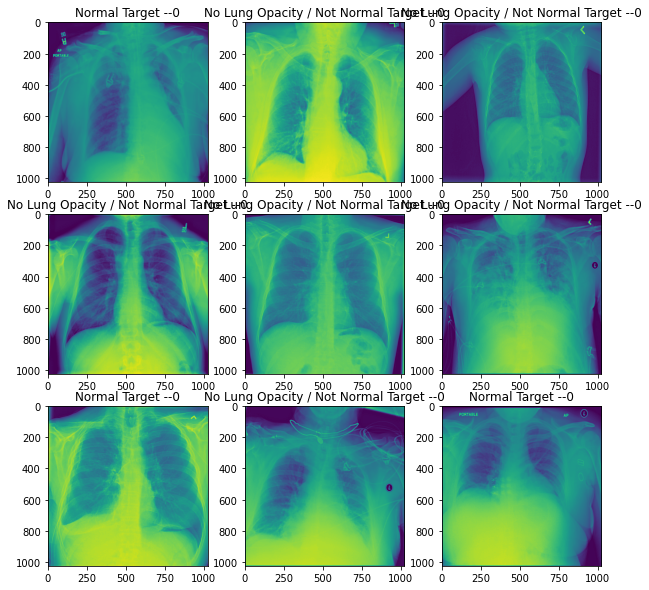

In [36]:
plot_images(not_infected_id) 